In [1]:
import torch
import os



#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
"""
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "4,5"

print("Available devices ", torch.cuda.device_count())
print("Current cuda devices ", torch.cuda.current_device())
print(torch.cuda.get_device_name(device))
"""



# GPU 할당 변경하기
GPU_NUM = 4  # 원하는 GPU 번호 입력
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')

torch.cuda.set_device(device) # change allocation of current GPU
print ('Current cuda device ', torch.cuda.current_device()) # check

# Additional Infos
if device.type == 'cuda':
    print(torch.cuda.get_device_name(GPU_NUM))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(GPU_NUM)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(GPU_NUM)/1024**3,1), 'GB')


Current cuda device  4
GeForce RTX 2080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [7]:
import time
import math
import random
import librosa
import librosa.display
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import plot_confusion_matrix
from torch.utils.data import Dataset, DataLoader, TensorDataset


''''''
BATCH_SIZE = 20
EPOCHS = 100
lr = 2*10e-5
''''''


path = 'data/'

In [8]:
def dB( magnitude ):

    decibel = 20*np.log10( np.abs(magnitude) + np.finfo(float).eps )    
    return decibel




def normalization( L, R ):

    LR = np.asarray( [ L, R ] )
    mu = np.mean( LR )
    sigma = np.std( LR )
    z = ( LR - mu ) / sigma
    
    return z[0], z[1]



from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MaxAbsScaler



def scaler( L, R):
    LR = np.concatenate( (L,R), axis=0 )
    #z = MinMaxScaler().fit_transform(LR[:])
    z = StandardScaler().fit_transform(LR[:])
    #z = RobustScaler().fit_transform(LR[:])
    #z = MaxAbsScaler().fit_transform(LR[:])
    z = z.reshape(2, 257, 382)
    return z[0], z[1]




def angle_to_digit( y_data ):
    
    for idx in range(y_data.shape[0]):
        
        y = y_data[idx]
        if y<0: y_data[idx] = 10
        else:   y_data[idx] = ( y//20 )
    
    return y_data

In [10]:
x_data = ['S_left.npy', 'S_right.npy', 'S_left_phase.npy','S_right_phase.npy']
y_data = np.load(path+ 'angle.npy')


S_left  = np.load( path + x_data[0] )
S_right = np.load( path + x_data[1] )
S_left_phase  = np.load( path + x_data[2] )
S_right_phase = np.load( path + x_data[3] )

In [11]:
x_data = []

for idx in range( y_data.shape[0] ):
    
    x_element = []
    
    mag_L = S_left[:,:,idx]
    mag_R = S_right[:,:,idx]
    phi_L = S_left_phase[:,:,idx]
    phi_R = S_right_phase[:,:,idx]


    """log[dB] scale"""
    log_L = dB( mag_L )
    log_R = dB( mag_R )


    """정규화"""
    # z_mag = normalization( log_L, log_R )
    # z_phi = normalization( phi_L, phi_R )

    #z_mag = scaler( mag_L, mag_R )
    z_mag = scaler( log_L, log_R )
    z_phi = scaler( phi_L, phi_R )
    
    x_left_mag ,  x_right_mag   =  z_mag
    x_left_phase, x_right_phase =  z_phi


    x_element.append( x_left_mag )
    x_element.append( x_right_mag )
    x_element.append( x_left_phase )
    x_element.append( x_right_phase )

    
    x_data.append( np.asarray(x_element) )


x_data = np.asarray(x_data)
y_data = angle_to_digit(y_data)

[140]


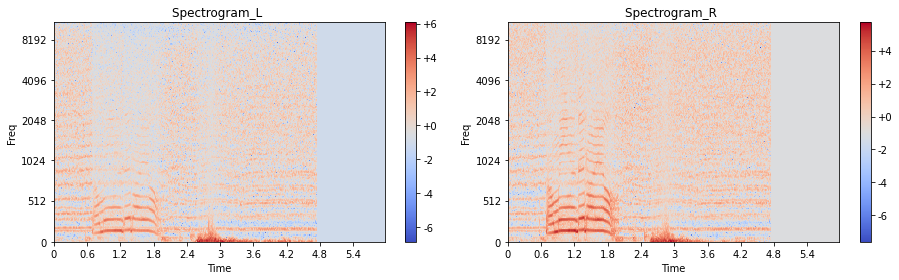

In [12]:
i = 200
Freq = 16000

x_data_L = x_data[i-1][0]
x_data_R = x_data[i-1][1]
print(y_data[i-1]*20)


plt.figure(figsize=(13,4))

plt.subplot(121)
librosa.display.specshow(x_data_L, sr=Freq, hop_length=250, x_axis='time', y_axis='mel')
plt.xlabel('Time')
plt.ylabel('Freq')
plt.colorbar(format="%+2.0f")
plt.title('Spectrogram_L ')

plt.subplot(122)
librosa.display.specshow(x_data_R, sr=Freq, hop_length=250, x_axis='time', y_axis='mel')
plt.xlabel('Time')
plt.ylabel('Freq')
plt.colorbar(format="%+2.0f")
plt.title('Spectrogram_R ')


plt.tight_layout()
plt.show()


In [13]:

train_size = 800
valid_size = 200

x_data = torch.from_numpy( x_data ).float().to(device)
y_data = torch.from_numpy( y_data ).long().to(device).reshape(1000,)

full_dataset = TensorDataset( x_data, y_data )


train_data, valid_data = torch.utils.data.random_split( full_dataset, [train_size, valid_size] )
train_dataset = DataLoader( dataset=train_data, batch_size = BATCH_SIZE, shuffle=True, drop_last=True)
valid_dataset = DataLoader( dataset=valid_data, batch_size = BATCH_SIZE, shuffle=True, drop_last=True)

In [2]:

from collections import OrderedDict
from torch import Tensor


class _DenseLayer(nn.Module):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate, memory_efficient=False):
        super(_DenseLayer, self).__init__()
        
        self.add_module('norm1', nn.BatchNorm2d(num_input_features)),
        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size * growth_rate,
                                           kernel_size=1, stride=1,bias=False)),
        
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate)),
        self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                                           kernel_size=3, stride=1, padding=1,
                                           bias=False)),
        
        self.drop_rate = float(drop_rate)
        self.memory_efficient = memory_efficient

    def bn_function(self, inputs):
        # type: (List[Tensor]) -> Tensor
        concated_features = torch.cat(inputs, 1)
        bottleneck_output = self.conv1(self.relu1(self.norm1(concated_features)))  # noqa: T484
        
        return bottleneck_output


    def forward(self, input):  # noqa: F811
        if isinstance(input, Tensor):
            prev_features = [input]
        else:
            prev_features = input


        bottleneck_output = self.bn_function(prev_features)
        new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))
        
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate,
                                     training=self.training)
        
        return new_features




class _DenseBlock(nn.ModuleDict):
    _version = 2

    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate, memory_efficient=False):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient,
            )
            self.add_module('denselayer%d' % (i + 1), layer)

    def forward(self, init_features):
        features = [init_features]
        for name, layer in self.items():
            new_features = layer(features)
            features.append(new_features)
        return torch.cat(features, 1)





class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features,
                                          num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))




class DenseNet(nn.Module):
    '''growth_rate, drop_rate'''
    def __init__(self, growth_rate=20, block_config=(6, 12, 24, 16),
                 num_init_features=128, bn_size=4, drop_rate=0.10,
                 num_classes=11, memory_efficient=False):

        super(DenseNet, self).__init__()

        # First convolution
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(4, num_init_features, kernel_size=7, stride=2, padding=3, bias=False)),
            
            ('norm0', nn.BatchNorm2d(num_init_features)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))


        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient
            )
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate

            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features,
                                    num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)



    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out





def _densenet(arch, growth_rate, block_config, num_init_features, pretrained, progress, **kwargs):
    return DenseNet(growth_rate, block_config, num_init_features, **kwargs)



def densenet_custom(pretrained=False, progress=True, **kwargs):
    return _densenet('densenet_custom', 20, (5, 5, 5), 32, pretrained, progress, **kwargs)



NameError: name 'nn' is not defined

In [ ]:


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)





class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride



    def forward(self, x):
        identity = x

        out = self.conv1(x)    # 3x3 stride = stride
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)  # 3x3 stride = 1
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x) 

        out += identity
        out = self.relu(out)

        return out






class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x) # 1x1 stride = 1
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out) # 3x3 stride = stride
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out) # 1x1 planes, plaines * self.expansion
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out



class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=11, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        
        super(ResNet, self).__init__()
        
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        
        

        self.groups = groups
        self.base_width = width_per_group


        # input : 4 X 257 X 382
        self.conv1 = nn.Conv2d(4, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        
        # output = self.conv1( input )
        # output : 64 x 129 x 191
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)

        # input : 64 x 129 x 191
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # output : 64 x 150 x 96

        #[layers]
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)


    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)




    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)



def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model



def Resnet(pretrained=False, progress=True, **kwargs):

    return _resnet('resnet50', Bottleneck, [3, 5, 5, 5], pretrained, progress, **kwargs)

In [15]:
# DataParallel

#model = CNN().to(device)
#model = Resnet().to(device)
model = densenet_custom()
model = nn.DataParallel(model, device_ids=[4,5], output_device=4)
model = model.cuda()

In [16]:
torch.manual_seed(100)
criterion = nn.CrossEntropyLoss().to(device)


'''optimizer'''
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
TITLE = 'Adam'




train_loss = []
train_acc  = []


# confusion matrix를 만들기 위해서 
# 먼저 int type의 random값이 있는 
# (1,) size torch tensor 초기화
torch_pred  = torch.empty((1,), dtype=torch.int32).to(device)
torch_label = torch.empty((1,), dtype=torch.int32).to(device)



model.train()
for epoch in range(EPOCHS):
    #print('epoch ' + str(epoch+1))
    total_loss = 0.0
    total_acc = 0
    start = time.time()
    
    for i, (data, label) in enumerate(train_dataset):
        (data, label) = (data.to(device), label.to(device))

        #zero the parameter gradients
        optimizer.zero_grad()        

        # forward + backward = optimize
        output = model(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        

        """loss, accuracy"""
        # batch 정확도
        preds  = torch.max(output.data, 1)[1]
        corr  = (preds==label).sum().item()
        acc   = corr/BATCH_SIZE*100

        # epoch 손실도, 정확도
        total_loss += loss.item()
        total_acc += corr
    
        # batch 손실도, 정확도 출력, 저장
        #train_loss.append(loss)
        #train_acc.append(acc)


        """ confusion matrix"""
        # 마지막 epoch에서 
        if epoch == EPOCHS-1:
            torch_pred  = torch.cat( [ torch_pred , preds.to( device, dtype=torch.int32) ], dim=0 )
            torch_label = torch.cat( [ torch_label, label.to( device, dtype=torch.int32) ], dim=0 )


        

    # epoch 손실도, 정확도 출력
    #if (epoch) % 10 == 9:
    train_loss.append(total_loss)
    train_acc.append(total_acc/8)
    print('epoch' + str(epoch+1) + '  >> Loss: {:.3f}    Acc: {:.3f}%    time: {:.3f}sec'.format( total_loss, total_acc/8, time.time()-start ))
    #print()

epoch1  >> Loss: 96.121    Acc: 9.875%    time: 7.781sec
epoch2  >> Loss: 94.324    Acc: 14.250%    time: 2.818sec
epoch3  >> Loss: 93.601    Acc: 14.500%    time: 2.897sec
epoch4  >> Loss: 92.370    Acc: 18.625%    time: 2.818sec
epoch5  >> Loss: 90.356    Acc: 21.000%    time: 2.817sec
epoch6  >> Loss: 87.978    Acc: 26.375%    time: 2.817sec
epoch7  >> Loss: 84.667    Acc: 28.125%    time: 2.818sec
epoch8  >> Loss: 81.929    Acc: 34.875%    time: 2.827sec
epoch9  >> Loss: 79.284    Acc: 37.750%    time: 2.816sec
epoch10  >> Loss: 75.886    Acc: 40.125%    time: 2.819sec
epoch11  >> Loss: 73.538    Acc: 45.625%    time: 2.816sec
epoch12  >> Loss: 71.817    Acc: 41.750%    time: 2.907sec
epoch13  >> Loss: 68.026    Acc: 47.125%    time: 2.818sec
epoch14  >> Loss: 65.831    Acc: 48.625%    time: 2.828sec
epoch15  >> Loss: 64.394    Acc: 48.250%    time: 2.818sec
epoch16  >> Loss: 62.239    Acc: 53.125%    time: 2.837sec
epoch17  >> Loss: 59.924    Acc: 52.500%    time: 2.911sec
epoch18

<IPython.core.display.Javascript object>


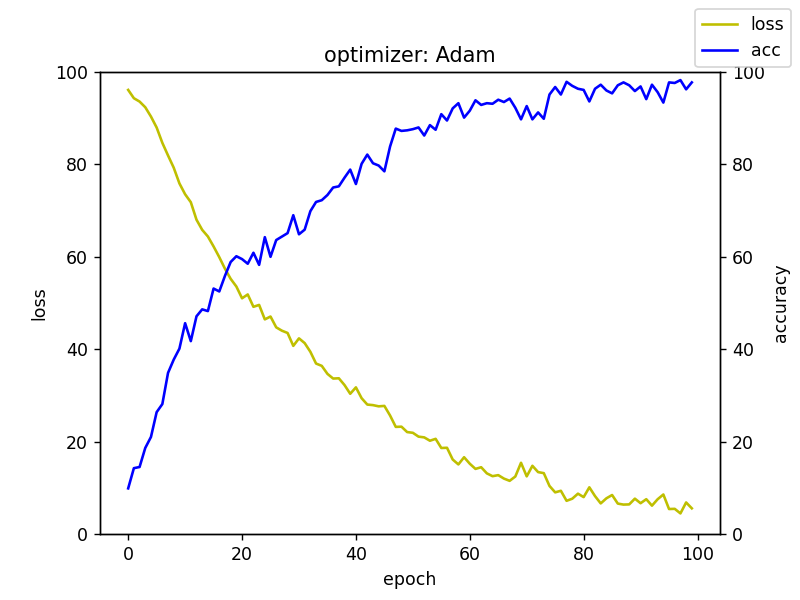

In [17]:

%matplotlib notebook
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(np.asarray(train_loss), 'y')
acc_ax.plot( np.asarray(train_acc),  'b')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.set_ylim([0, 100])

acc_ax.set_ylabel('accuracy')
acc_ax.set_ylim([0, 100])


fig.legend(['loss','acc'], loc='upper right')
plt.title('optimizer: '+TITLE)
#plt.savefig(PATH+TITLE+str(NUM)+'.png')
plt.show()

<IPython.core.display.Javascript object>


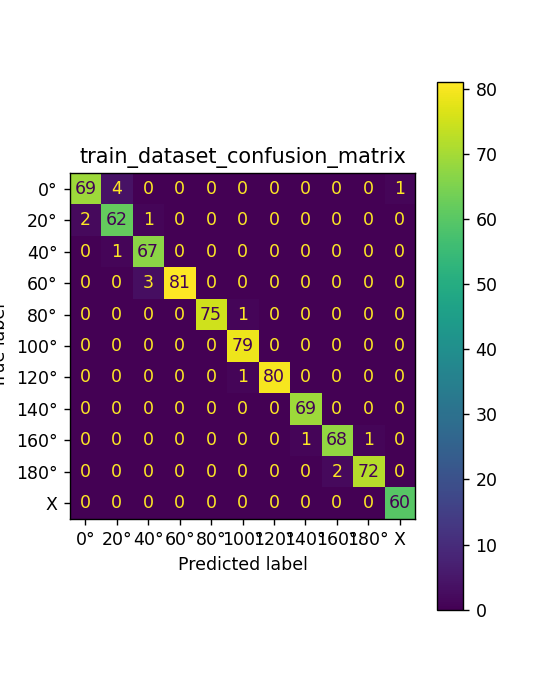

In [18]:
axis = ['0\u00b0','20\u00b0','40\u00b0','60\u00b0','80\u00b0','100\u00b0','120\u00b0','140\u00b0','160\u00b0','180\u00b0','X']
from sklearn.metrics import ConfusionMatrixDisplay as cmd

stacked = torch.stack( ( torch_label[1:], torch_pred[1:] ), dim=1 )
y_true = stacked[:,0].to('cpu')
y_pred = stacked[:,1].to('cpu')
confusion_matrix = cm(y_true, y_pred)


%matplotlib notebook
disp = cmd(confusion_matrix = confusion_matrix, display_labels=axis )
disp = disp.plot()

plt.title('train_dataset_confusion_matrix')
plt.gcf().set_size_inches(6,7,forward=True)

#plt.savefig( PATH + 'train_dataset_confusion_matrix' + str(NUM) + '.png' )
plt.show()



In [19]:
model.eval().to(device)



with torch.no_grad():
    correct = 0
    total = 0

    #confusion matrix
    torch_pred_valid  = torch.empty((1,), dtype=torch.int32).to(device)
    torch_label_valid = torch.empty((1,), dtype=torch.int32).to(device)

    for data, label in valid_dataset:
        output = model(data)
        preds  = torch.max(output.data, 1)[1]
        total += len(label)
        correct += (preds==label).sum().item()

        #confusion matrix
        torch_pred_valid  = torch.cat( [ torch_pred_valid , preds.to( device, dtype=torch.int32) ], dim=0 )
        torch_label_valid = torch.cat( [ torch_label_valid, label.to( device, dtype=torch.int32) ], dim=0 )


    valid_stacked = torch.stack( ( torch_label_valid[1:], torch_pred_valid[1:] ), dim=1 )

      
    print('Test Accuracy: ', 100.*correct/total)

Test Accuracy:  83.5


<IPython.core.display.Javascript object>


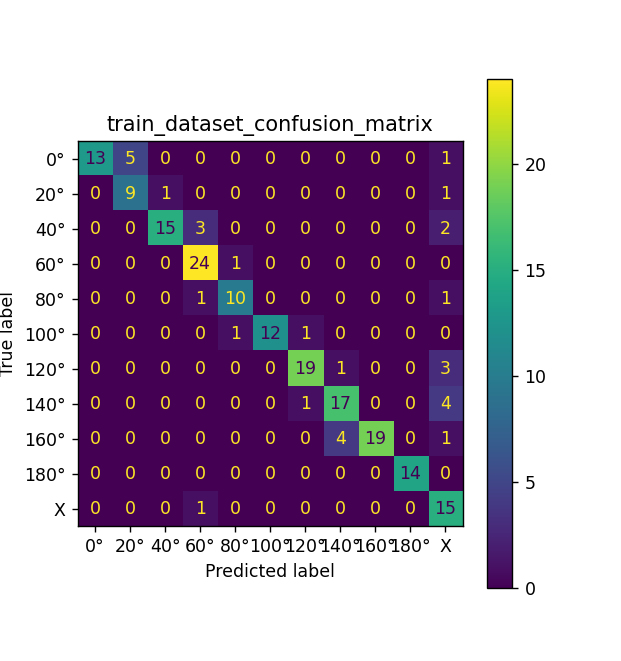

In [20]:

val_true = valid_stacked[:,0].to('cpu')
val_pred = valid_stacked[:,1].to('cpu')
val_confusion_matrix = cm(val_true, val_pred)


%matplotlib notebook
disp = cmd(confusion_matrix = val_confusion_matrix, display_labels=axis)
disp = disp.plot()

plt.title('train_dataset_confusion_matrix')
plt.gcf().set_size_inches(6,7,forward=True)

#plt.savefig( PATH + 'train_dataset_confusion_matrix' + str(NUM) + '.png' )
plt.show()